## This notebook builds a new data selection framework to build batting_runs inferential_models

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from IPython.display import Image

# import jupyter_black
# jupyter_black.load()

az.style.use("arviz-darkgrid")
RANDOM_SEED = 8265
np.random.seed(RANDOM_SEED)

np.set_printoptions(2)

# filter out Seaborn UserWarnings
warnings.filterwarnings(action="ignore", category=UserWarning, module=r"seaborn")
# warnings.filterwarnings(action="ignore", category=RuntimeWarning, module=r"scipy")
from warnings import simplefilter, warn

simplefilter("ignore")

In [2]:
import os
os.getcwd()

'/Users/gireeshramji/PycharmProjects/SouthridgeCorp/player-outcome-predictor/notebooks'

In [3]:
os.chdir("..")
os.getcwd()

'/Users/gireeshramji/PycharmProjects/SouthridgeCorp/player-outcome-predictor'

In [4]:
from utils.config_utils import ConfigUtils
from historical_data.singleton import Helper
from data_selection.data_selection import DataSelection
from rewards_configuration.rewards_configuration import RewardsConfiguration
from simulators.perfect_simulator import PerfectSimulator

In [5]:
import aesara.tensor as at

In [135]:
config_utils = ConfigUtils(".streamlit/config.toml")
helper = Helper(config_utils)
data_selection = DataSelection(helper)
rewards_config = RewardsConfiguration(config_utils)
perfect_simulator = PerfectSimulator(data_selection, rewards_config)

2022-11-16 13:24:24.707 INFO    root: Creating feedback form storage with method local


In [136]:
helper.tournaments.df

,key,name,first_match_date,last_match_date
0,t20s,International T20s,2005-02-17,2022-10-05
1,apl,Afghanistan Premier League,2018-10-05,2018-10-21
2,bbl,Big Bash League,2011-12-16,2022-01-28
3,bpl,Bangladesh Premier League,2012-02-11,2022-02-18
4,cpl,Caribbean Premier League,2013-07-30,2022-09-30
5,ctc,CSA T20 Challenge,2012-02-15,2022-02-27
6,ipl,Indian Premier League,2008-04-18,2022-05-29
7,lpl,Lanka Premier League,2020-11-26,2021-12-23
8,psl,Pakistan Super League,2016-02-04,2022-02-27
9,ssm,Super Smash,2013-01-20,2022-01-29


In [137]:
selected_tournament = 'Indian Premier League'
tournament_start_date = helper.tournaments.df.query(f'name == "{selected_tournament}"').first_match_date.iloc[0]
tournament_end_date = helper.tournaments.df.query(f'name == "{selected_tournament}"').last_match_date.iloc[0]

In [138]:
helper.tournaments.set_selected_tournament_names([selected_tournament])
helper.tournaments.set_start_end_dates(tournament_start_date, tournament_end_date, False)

In [139]:
helper.tournaments.get_selected_tournaments()

['ipl']

In [140]:
helper.tournaments.get_start_end_dates(False)

(datetime.date(2008, 4, 18), datetime.date(2022, 5, 29))

In [141]:
all_matches_for_tournament = data_selection.get_selected_matches(False)

In [142]:
all_bowling_outcomes_for_tournament = perfect_simulator.get_bowling_outcomes_by_ball_and_innings(False)
all_match_states_for_tournament = perfect_simulator.get_match_state_by_ball_and_innings(False)

In [143]:
all_matches_for_tournament.season.value_counts()

2013       76
2012       74
2022       74
2011       73
2021       60
2019       60
2016       60
2014       60
2020/21    60
2018       60
2009/10    60
2015       59
2017       59
2007/08    58
2009       57
Name: season, dtype: int64

In [272]:
test_season = '2009'

In [273]:
test_season_matches = all_matches_for_tournament.query(f'season == "{test_season}"')

In [274]:
test_start_date = test_season_matches.date.min()
test_end_date = test_season_matches.date.max()

In [275]:
(test_start_date,test_end_date)

(datetime.date(2009, 4, 18), datetime.date(2009, 5, 24))

In [276]:
test_season_venues = test_season_matches.venue.unique().tolist()
test_season_match_keys = test_season_matches.key.unique().tolist()

In [277]:
test_season_match_state_df = all_match_states_for_tournament.query('match_key in @test_season_match_keys')
test_season_bowling_outcomes_df = all_bowling_outcomes_for_tournament.query('match_key in @test_season_match_keys')

In [278]:
test_season_batters = test_season_match_state_df.batter.unique().tolist()
test_season_bowlers = test_season_match_state_df.bowler.unique().tolist()

In [279]:
previous_season = '2007/08'
previous_season_matches = all_matches_for_tournament.query(f'season == "{previous_season}"')
previous_season_end_date = previous_season_matches.date.max()

In [280]:
previous_season_end_date

datetime.date(2008, 6, 1)

In [281]:
#Now we know all the batters, bowlers and venues that we need to query for training data.
#So we choose all tournaments and set the training window to precede the test window
helper.tournaments.set_selected_tournament_names(helper.tournaments.df.name.tolist())
helper.tournaments.set_start_end_dates(helper.tournaments.df.first_match_date.min(), 
                                       test_start_date, 
                                       False)


In [282]:
helper.tournaments.get_selected_tournaments()

['t20s',
 'apl',
 'bbl',
 'bpl',
 'cpl',
 'ctc',
 'ipl',
 'lpl',
 'psl',
 'ssm',
 'ntb',
 'msl']

In [283]:
helper.tournaments.get_start_end_dates(False)

(datetime.date(2005, 2, 17), datetime.date(2009, 4, 18))

In [284]:
helper.tournaments.get_start_end_dates(True)

(datetime.date(2005, 2, 17), datetime.date(2022, 10, 5))

In [285]:
am = data_selection.get_selected_matches(False)

In [286]:
(am.date.min(),am.date.max())

(datetime.date(2005, 2, 17), datetime.date(2009, 4, 18))

In [287]:
unqualified_train_bowling_outcomes_df = perfect_simulator.get_bowling_outcomes_by_ball_and_innings(False)
unqualified_train_match_state_df = perfect_simulator.get_match_state_by_ball_and_innings(False)

In [288]:
unqualified_train_bowling_outcomes_df.shape

(30550, 20)

In [289]:
is_test_season_venue = unqualified_train_match_state_df.venue.isin(test_season_venues)
is_test_season_batter = unqualified_train_match_state_df.batter.isin(test_season_batters)
is_test_season_bowler = unqualified_train_match_state_df.bowler.isin(test_season_bowlers)

In [290]:
train_match_state_df = unqualified_train_match_state_df.loc[is_test_season_venue | is_test_season_batter | is_test_season_bowler]
train_bowling_outcomes_df = unqualified_train_bowling_outcomes_df.loc[is_test_season_venue | is_test_season_batter | is_test_season_bowler]

In [291]:
frequent_players_set = set(test_season_batters + test_season_bowlers)

In [292]:
train_match_state_df.shape

(25612, 611)

In [293]:
train_match_state_df.query('bowler in @test_season_bowlers').shape

(15880, 611)

In [294]:
train_bowlers = train_match_state_df.bowler.unique().tolist()
train_batters= train_match_state_df.batter.unique().tolist()

In [295]:
test_season_match_state_df.query('batter in @train_batters').shape

(12511, 419)

In [296]:
test_season_match_state_df.query('bowler in @train_bowlers').shape

(11582, 419)

In [297]:
test_season_match_state_df.shape

(13606, 419)

## Building new features and targets

In [298]:
def batter_featured_id(df):
    c1 = df['batter'].isin(frequent_players_set)
    df.loc[c1,'batter_featured_id'] = df['batter']
    df['batter_featured_id'].fillna('non_frequent_player',inplace=True)
    
def bowler_featured_id(df):
    c1 = df['batter'].isin(frequent_players_set)
    df.loc[c1,'bowler_featured_id'] = df['bowler']
    df['bowler_featured_id'].fillna('non_frequent_player',inplace=True)
    
def is_legal_delivery(df):
    c1 = df.noballs.isna() 
    c2 = df.wides.isna()
    df.loc[c1&c2,'is_legal_delivery'] = True
    df['is_legal_delivery'].fillna(False,inplace=True)
    
def striker_dismissed(df):
    c1 = (df['batter'] == df['player_dismissed'])
    c2 = (df['player_dismissed'].isna()==False)
    df.loc[c1&c2,'striker_dismissed'] = True
    c3 = (df['batter'] != df['player_dismissed'])
    df.loc[c3 & c2,'striker_dismissed'] = False

def innings_strike_rate(df):
    df['innings_strike_rate'] = df['current_total']/df['total_balls_bowled']
    df['innings_strike_rate'].fillna(0,inplace=True)
    max_value = np.nanmax(df[['innings_strike_rate']][df['innings_strike_rate'] != np.inf])
    df['innings_strike_rate'].replace([np.inf, -np.inf], max_value, inplace=True)

    
def add_column_to_df(df,
                     column_name):
    column_name(df)

In [299]:
for df in [train_match_state_df,
           test_season_match_state_df]:
    for column in [batter_featured_id,
                   bowler_featured_id,
                   innings_strike_rate]:
        add_column_to_df(df,
                         column)

In [300]:
for df in [train_bowling_outcomes_df,
           test_season_bowling_outcomes_df]:
    for column in [is_legal_delivery,
                   striker_dismissed]:
        add_column_to_df(df,
                         column)

In [301]:
for df in [train_match_state_df,
           test_season_match_state_df,
           train_bowling_outcomes_df,
           test_season_bowling_outcomes_df]:
    df.reset_index(inplace=True)

In [302]:
train_match_state_df.innings_strike_rate.max()

8.0

## Building Categoricals for Indexing

In [303]:
def build_categoricals_for_column(df,column):
    categorical = pd.Categorical(df[column])
    return categorical.categories
    
def get_categorical_column_index_for_df(df,
                            categories,
                            column):
    idx = pd.Categorical(df[column],
                         categories).codes
    return idx

In [304]:
COORDS = {}
train_feature_data = {}
test_feature_data = {}
all_feature_data = {}
for dim in ['batter_featured_id',
            'bowler_featured_id',
            'batting_team',
            'bowling_team',
            'venue',
            'wickets_fallen',
            'over',
            'match_key',
            'inning',
            'ball']:
    categories = build_categoricals_for_column(test_season_match_state_df,
                                               dim)
    COORDS[dim] = categories
    train_feature_data[dim] = get_categorical_column_index_for_df(train_match_state_df,
                                                                  categories,
                                                                  dim)
    test_feature_data[dim] = get_categorical_column_index_for_df(test_season_match_state_df,
                                                              categories,
                                                              dim)

In [305]:
for dim in ['innings_strike_rate']:
    train_feature_data[dim] = train_match_state_df[dim]
    test_feature_data[dim] = test_season_match_state_df[dim]

In [306]:
train_outcome_data = {}
test_outcome_data = {}
all_outcome_data = {}
for dim in ['batter_runs',
            'extras',
            'is_legal_delivery',
            'is_wicket',
            'wides',
            'noballs',
            'dismissal_kind',
            'is_direct_runout']:
    categories = build_categoricals_for_column(train_bowling_outcomes_df,
                                               dim)
    COORDS[dim] = categories
    train_outcome_data[dim] = get_categorical_column_index_for_df(train_bowling_outcomes_df,
                                                                  categories,
                                                                  dim)
    test_outcome_data[dim] = get_categorical_column_index_for_df(test_season_bowling_outcomes_df,
                                                              categories,
                                                              dim)

In [307]:
COORDS

{'batter_featured_id': Index(['AAr1948', 'ABa3507', 'ACa3489', 'ADa1260', 'AFf997', 'AGh3600',
        'AGt990', 'AKe3514', 'AMa1185', 'AMd2912',
        ...
        'WMa3611', 'WSa3464', 'WVs1108', 'YNr3492', 'YPn1126', 'YSh3488',
        'YSh604', 'YTe3551', 'YVRo3456', 'ZKn743'],
       dtype='object', length=150),
 'bowler_featured_id': Index(['AAr1948', 'ADa1260', 'AFf997', 'AKe3514', 'AMa1185', 'AMd2912',
        'AMn3593', 'AMs106', 'AMs1940', 'ANa722',
        ...
        'VSg740', 'VSh3447', 'WMa3611', 'WVs1108', 'YAa2294', 'YNr3492',
        'YPn1126', 'YSh604', 'YVRo3456', 'ZKn743'],
       dtype='object', length=112),
 'batting_team': Index(['Chennai Super Kings', 'Deccan Chargers', 'Delhi Daredevils',
        'Kings XI Punjab', 'Kolkata Knight Riders', 'Mumbai Indians',
        'Rajasthan Royals', 'Royal Challengers Bangalore'],
       dtype='object'),
 'bowling_team': Index(['Chennai Super Kings', 'Deccan Chargers', 'Delhi Daredevils',
        'Kings XI Punjab', 'Kolkata 

In [308]:
train_feature_data

{'batter_featured_id': array([-1, -1, -1, ..., 55, 55, 55], dtype=int16),
 'bowler_featured_id': array([-1, -1, -1, ..., 43, 43,  3], dtype=int8),
 'batting_team': array([-1, -1, -1, ...,  6,  6,  6], dtype=int8),
 'bowling_team': array([-1, -1, -1, ...,  7,  7,  7], dtype=int8),
 'venue': array([-1, -1, -1, ...,  4,  4,  4], dtype=int8),
 'wickets_fallen': array([ 0,  0,  0, ...,  9,  9, 10], dtype=int8),
 'over': array([ 0,  0,  0, ..., 14, 14, 15], dtype=int8),
 'match_key': array([-1, -1, -1, ...,  1,  1,  1], dtype=int8),
 'inning': array([0, 0, 0, ..., 1, 1, 1], dtype=int8),
 'ball': array([0, 1, 2, ..., 4, 5, 0], dtype=int8),
 'innings_strike_rate': 0        0.000000
 1        1.000000
 2        0.500000
 3        0.333333
 4        0.250000
            ...   
 25607    0.585106
 25608    0.578947
 25609    0.593750
 25610    0.597938
 25611    0.591837
 Name: innings_strike_rate, Length: 25612, dtype: float64}

In [309]:
test_feature_data

{'batter_featured_id': array([117, 127, 127, ..., 105, 105, 105], dtype=int16),
 'bowler_featured_id': array([54, 54, 54, ..., 77, 77, 77], dtype=int8),
 'batting_team': array([5, 5, 5, ..., 7, 7, 7], dtype=int8),
 'bowling_team': array([0, 0, 0, ..., 1, 1, 1], dtype=int8),
 'venue': array([4, 4, 4, ..., 3, 3, 3], dtype=int8),
 'wickets_fallen': array([0, 0, 0, ..., 9, 9, 9], dtype=int8),
 'over': array([ 0,  0,  0, ..., 19, 19, 19], dtype=int8),
 'match_key': array([ 0,  0,  0, ..., 56, 56, 56], dtype=int8),
 'inning': array([0, 0, 0, ..., 1, 1, 1], dtype=int8),
 'ball': array([0, 1, 2, ..., 3, 4, 5], dtype=int8),
 'innings_strike_rate': 0        8.000000
 1        1.000000
 2        0.500000
 3        0.666667
 4        0.500000
            ...   
 13601    1.120690
 13602    1.111111
 13603    1.118644
 13604    1.142857
 13605    1.141667
 Name: innings_strike_rate, Length: 13606, dtype: float64}

In [310]:
def build_xarray(feature_dict,
                 outcome_dict,
                 index_df):
    feature_df = pd.DataFrame(feature_dict)
    feature_df.index = index_df.index
    outcome_df = pd.DataFrame(outcome_dict)
    outcome_df.index = index_df.index
    combined_df = pd.merge(outcome_df,
                           feature_df,
                           left_index = True,
                           right_index = True)
    return combined_df, combined_df.to_xarray()

In [311]:
train_combined_df,train_combined_xarray = build_xarray(train_feature_data,
                                                         train_outcome_data,
                                                         train_match_state_df)

In [312]:
test_combined_df,test_combined_xarray = build_xarray(test_feature_data,
                                                         test_outcome_data,
                                                         test_season_match_state_df)

<AxesSubplot: xlabel='batter_runs', ylabel='innings_strike_rate'>

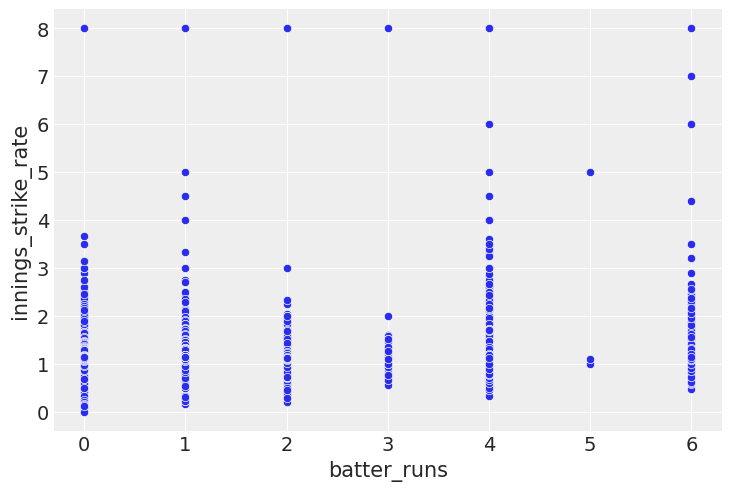

In [313]:
sns.scatterplot(
    data = test_combined_df,
    x = 'batter_runs',
    y = 'innings_strike_rate'
)

<AxesSubplot: xlabel='batter_runs', ylabel='innings_strike_rate'>

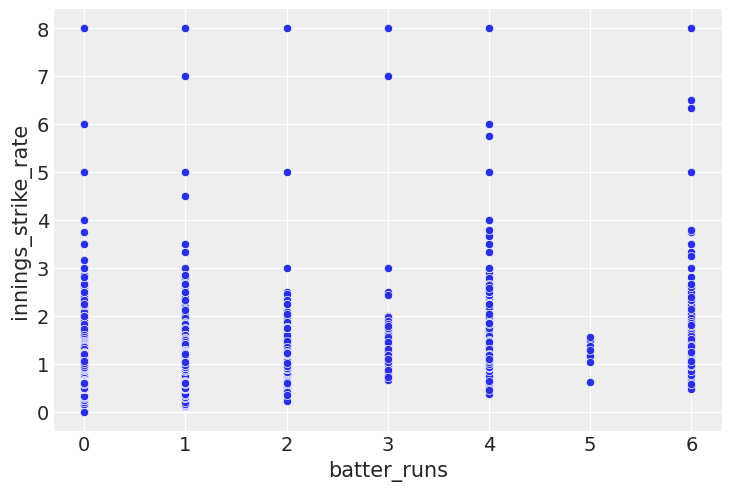

In [314]:
sns.scatterplot(
    data = train_combined_df,
    x = 'batter_runs',
    y = 'innings_strike_rate'
)

<AxesSubplot: xlabel='wickets_fallen', ylabel='innings_strike_rate'>

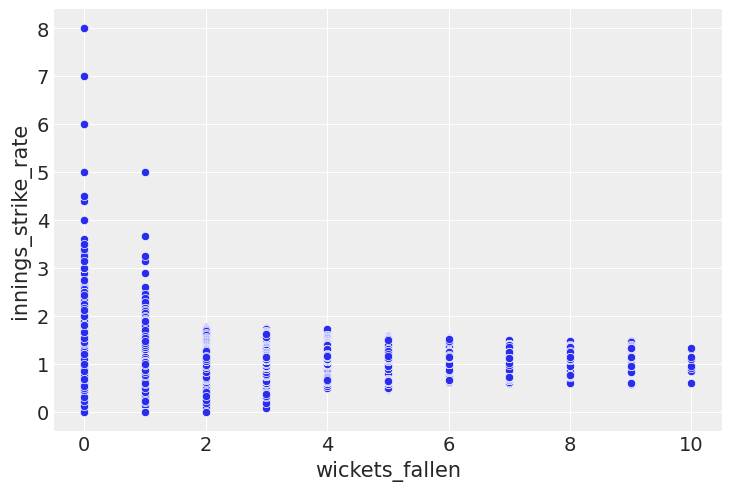

In [315]:
sns.scatterplot(
    data = test_combined_df,
    x = 'wickets_fallen',
    y = 'innings_strike_rate'
)

<AxesSubplot: xlabel='wickets_fallen', ylabel='innings_strike_rate'>

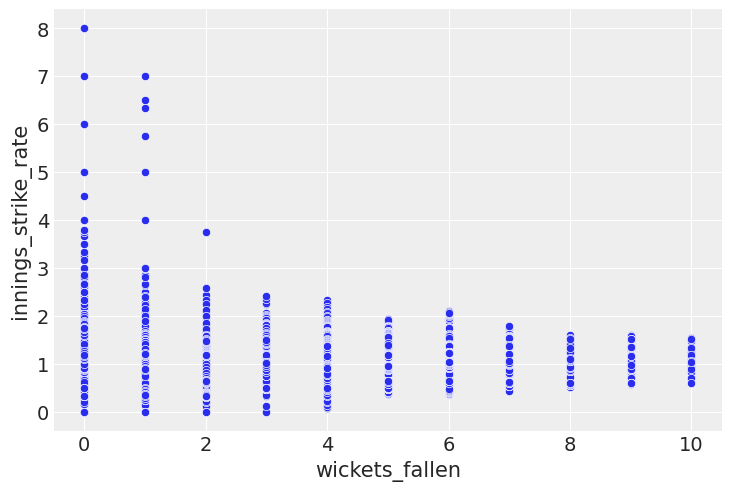

In [316]:
sns.scatterplot(
    data = train_combined_df,
    x = 'wickets_fallen',
    y = 'innings_strike_rate'
)

## Adding Data to the PyMC Model

In [317]:
with pm.Model(coords=COORDS) as first_innings_model:
    first_innings_model.add_coord('ball_ids',
                                   values = np.arange(train_combined_df.shape[0]),
                                   mutable = True)
    is_legal_delivery_outcomes_data = pm.MutableData("is_legal_delivery_outcomes_data",
                                                     train_combined_df['is_legal_delivery'],
                                                     dims = 'ball_ids')
    batter_runs_outcomes_data = pm.MutableData("batter_runs_outcomes_data",
                                               train_combined_df['batter_runs'],
                                               dims = 'ball_ids')
    batter_featured_id_feature_data = pm.MutableData("batter_featured_id_feature_data",
                                                     train_combined_df['batter_featured_id'],
                                                     dims = 'ball_ids')
    bowler_featured_id_feature_data = pm.MutableData("bowler_featured_id_feature_data",
                                                 train_combined_df['bowler_featured_id'],
                                                 dims = 'ball_ids')
    venue_feature_data = pm.MutableData("venue_feature_data",
                                        train_combined_df['venue'],
                                        dims = 'ball_ids')
    batting_team_feature_data = pm.MutableData("batting_team_feature_data",
                                    train_combined_df['batting_team'],
                                    dims = 'ball_ids')
    bowling_team_feature_data = pm.MutableData("bowling_team_feature_data",
                                    train_combined_df['bowling_team'],
                                    dims = 'ball_ids')
    over_feature_data = pm.MutableData("over_feature_data",
                                    train_combined_df['over'],
                                    dims = 'ball_ids')
    inning_feature_data = pm.MutableData("inning_feature_data",
                                    train_combined_df['inning'],
                                    dims = 'ball_ids')
    wickets_fallen_feature_data = pm.MutableData("wickets_fallen_feature_data",
                                train_combined_df['wickets_fallen'],
                                dims = 'ball_ids')
    is_wicket_outcome_data = pm.MutableData("is_wicket_outcome_data",
                                train_combined_df['is_wicket'],
                                dims = 'ball_ids')

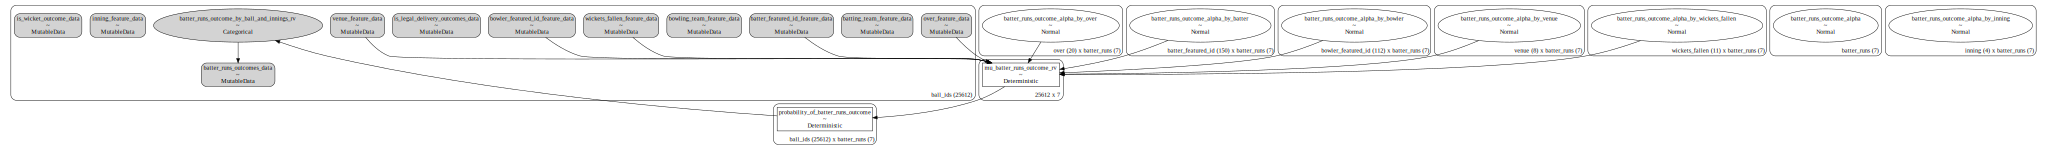

In [318]:
with first_innings_model:
    batter_runs_outcome_alpha = pm.Normal('batter_runs_outcome_alpha',
                                         mu=0,
                                         sigma=3,
                                         dims='batter_runs')
    batter_runs_outcome_alpha_by_over = pm.Normal('batter_runs_outcome_alpha_by_over',
                                                mu = 0,
                                                sigma = 3.0,
                                                dims = ('over',
                                                        'batter_runs'))
    batter_runs_outcome_alpha_mu_by_batter_global = 0
    batter_runs_outcome_alpha_sigma_by_batter_global = 3.0
    batter_runs_outcome_alpha_by_batter = pm.Normal('batter_runs_outcome_alpha_by_batter',
                                                    mu = batter_runs_outcome_alpha_mu_by_batter_global,
                                                    sigma = batter_runs_outcome_alpha_sigma_by_batter_global,
                                                    dims = ('batter_featured_id',
                                                            'batter_runs'))
    batter_runs_outcome_alpha_by_inning = pm.Normal('batter_runs_outcome_alpha_by_inning',
                                                    mu = 0,
                                                    sigma = 3.0,
                                                    dims = ('inning',
                                                            'batter_runs'))
    batter_runs_outcome_alpha_by_bowler = pm.Normal('batter_runs_outcome_alpha_by_bowler',
                                                    mu = 0,
                                                    sigma = 3.0,
                                                    dims = ('bowler_featured_id',
                                                            'batter_runs'))
    '''batter_runs_outcome_alpha_by_batting_team = pm.Normal('batter_runs_outcome_alpha_by_batting_team',
                                                    mu = 0,
                                                    sigma = 3.0,
                                                    dims = ('batting_team',
                                                            'batter_runs'))
    batter_runs_outcome_alpha_by_bowling_team = pm.Normal('batter_runs_outcome_alpha_by_bowling_team',
                                                    mu = 0,
                                                    sigma = 3.0,
                                                    dims = ('bowling_team',
                                                            'batter_runs'))'''
    batter_runs_outcome_alpha_by_venue = pm.Normal('batter_runs_outcome_alpha_by_venue',
                                                    mu = 0,
                                                    sigma = 3.0,
                                                    dims = ('venue',
                                                            'batter_runs'))

    batter_runs_outcome_alpha_by_wickets_fallen = pm.Normal('batter_runs_outcome_alpha_by_wickets_fallen',
                                                    mu = 0,
                                                    sigma = 3.0,
                                                    dims = ('wickets_fallen',
                                                            'batter_runs'))
    '''batter_runs_outcome_alpha_by_is_wicket = pm.Normal('batter_runs_outcome_alpha_by_is_wicket',
                                                    mu = 0,
                                                    sigma = 3.0,
                                                    dims = ('is_wicket',
                                                            'batter_runs'))'''
    batter_runs_outcome_mu = pm.Deterministic('mu_batter_runs_outcome_rv',
                                                        #batter_runs_outcome_alpha+
                                                        batter_runs_outcome_alpha_by_batter[batter_featured_id_feature_data]+
                                                        batter_runs_outcome_alpha_by_bowler[bowler_featured_id_feature_data]+
                                                        batter_runs_outcome_alpha_by_over[over_feature_data]+
                                                        batter_runs_outcome_alpha_by_wickets_fallen[wickets_fallen_feature_data]+
                                                        #batter_runs_outcome_alpha_by_is_wicket[is_wicket_outcome_data]+
                                                        batter_runs_outcome_alpha_by_venue[venue_feature_data])
    probability_of_batter_runs_outcome_rv = pm.Deterministic('probability_of_batter_runs_outcome',
                                                         at.nnet.softmax(batter_runs_outcome_mu),
                                                         dims = ('ball_ids','batter_runs'))
    batter_outcomes_by_ball_and_innings_rv = pm.Categorical('batter_runs_outcome_by_ball_and_innings_rv',
                                                         p=probability_of_batter_runs_outcome_rv,
                                                         observed=batter_runs_outcomes_data,
                                                         dims = 'ball_ids')

pm.model_to_graphviz(first_innings_model)

In [319]:
with first_innings_model:
    idata = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
2022-11-16 14:16:29.599 INFO    pymc: Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-11-16 14:16:29.601 INFO    pymc: Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
2022-11-16 14:16:35.583 INFO    pymc: Multiprocess sampling (4 chains in 4 jobs)
NUTS: [batter_runs_outcome_alpha, batter_runs_outcome_alpha_by_over, batter_runs_outcome_alpha_by_batter, batter_runs_outcome_alpha_by_inning, batter_runs_outcome_alpha_by_bowler, batter_runs_outcome_alpha_by_venue, batter_runs_outcome_alpha_by_wickets_fallen]
2022-11-16 14:16:35.584 INFO    pymc: NUTS: [batter_runs_outcome_alpha, batter_runs_outcome_alpha_by_over, batter_runs_outcome_alpha_by_batter, batter_runs_outcome_alpha_by_inning, batter_runs_outcome_alpha_by_bowler, batter_runs_outcome_alpha_by_venue, batter_runs_outcome_alpha_by_wickets_fallen]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16435 seconds.
2022-11-16 18:50:31.699 INFO    pymc: Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16435 seconds.


array([[<AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n0'}>,
        <AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n1'}>,
        <AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n2'}>],
       [<AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n3'}>,
        <AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n4'}>,
        <AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n5'}>],
       [<AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n6'}>,
        <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

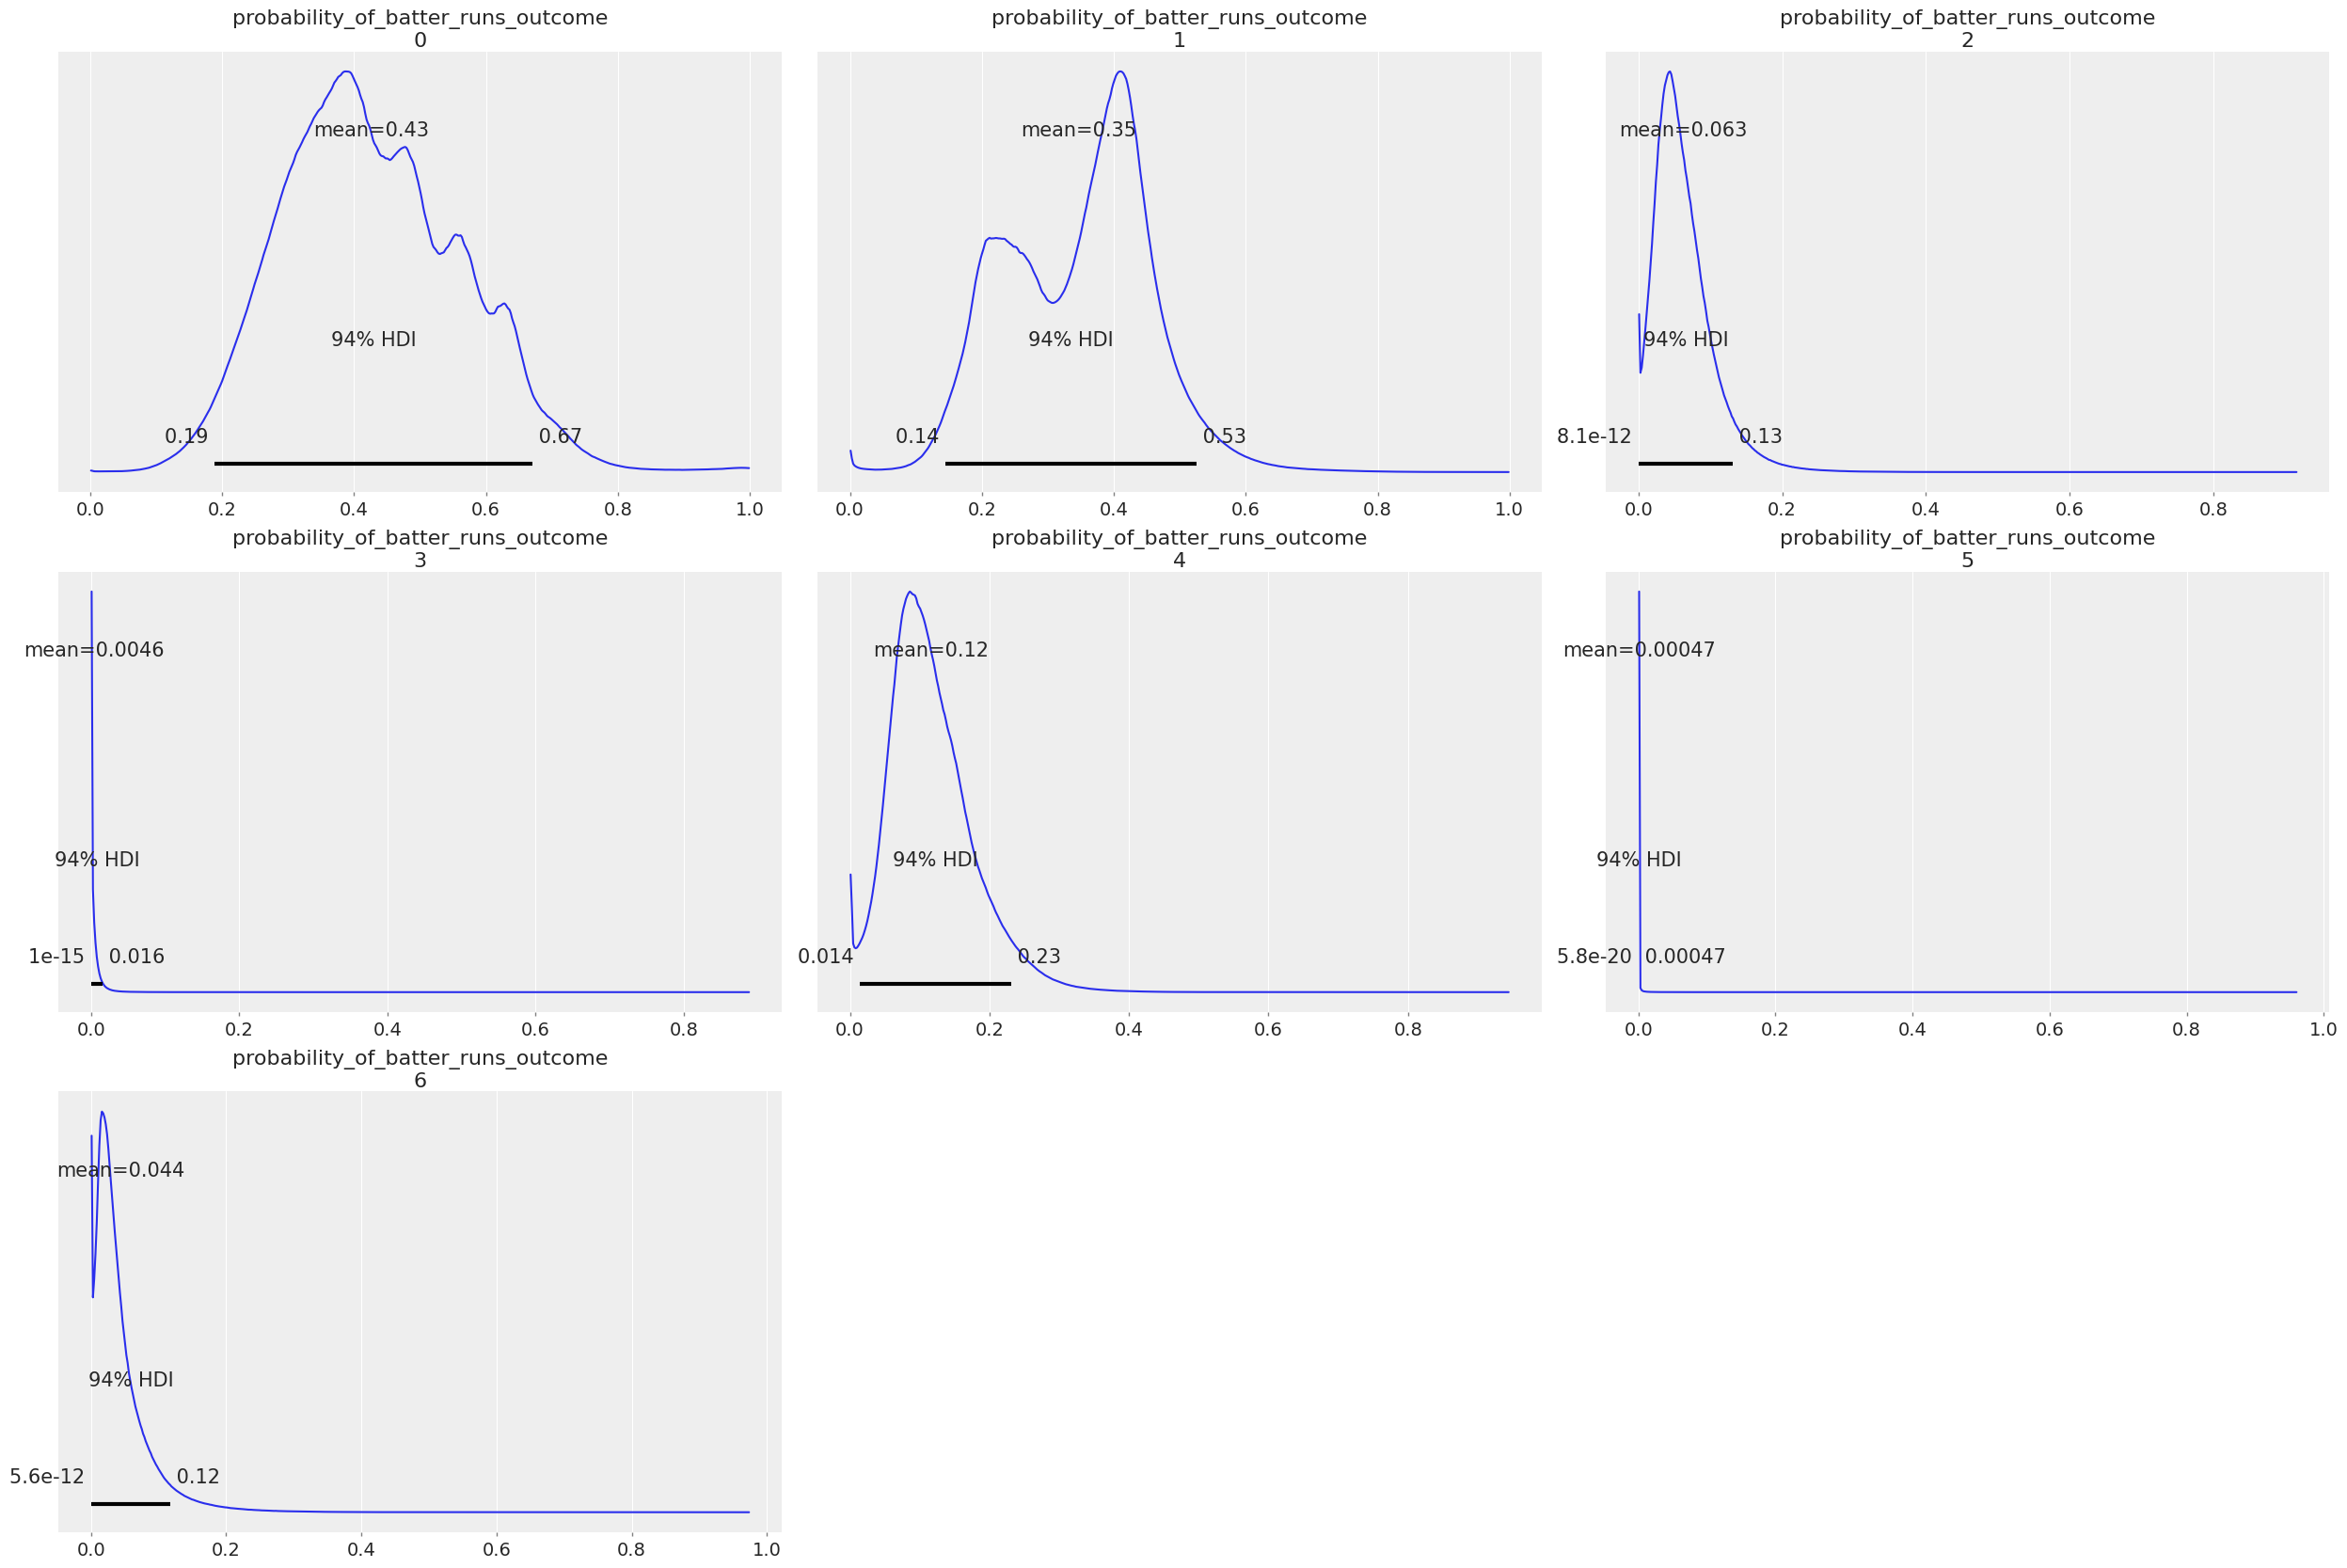

In [320]:
az.plot_posterior(idata.posterior,
                  var_names = ['probability_of_batter_runs_outcome'],
                  combine_dims = {'chain','draw','ball_ids'})

<AxesSubplot: >

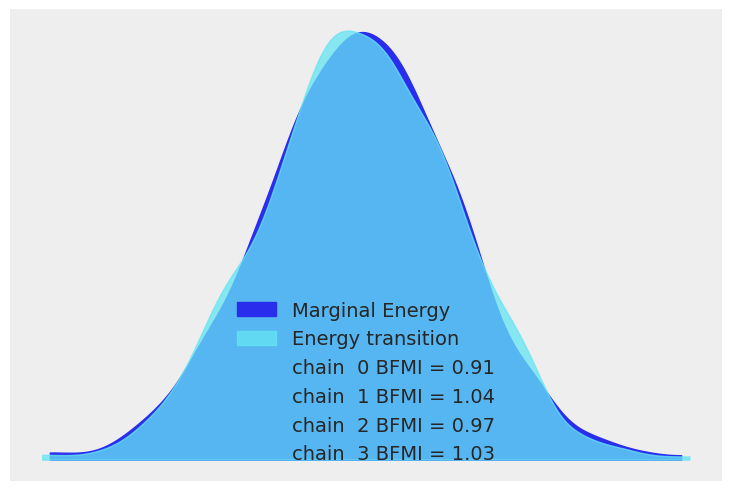

In [321]:
az.plot_energy(idata)

In [322]:
with first_innings_model:
    idata.extend(pm.sample_prior_predictive(random_seed=RANDOM_SEED))
    idata.extend(pm.sample_posterior_predictive(idata,random_seed=RANDOM_SEED))

Sampling: [batter_runs_outcome_alpha, batter_runs_outcome_alpha_by_batter, batter_runs_outcome_alpha_by_bowler, batter_runs_outcome_alpha_by_inning, batter_runs_outcome_alpha_by_over, batter_runs_outcome_alpha_by_venue, batter_runs_outcome_alpha_by_wickets_fallen, batter_runs_outcome_by_ball_and_innings_rv]
2022-11-16 18:57:14.285 INFO    pymc: Sampling: [batter_runs_outcome_alpha, batter_runs_outcome_alpha_by_batter, batter_runs_outcome_alpha_by_bowler, batter_runs_outcome_alpha_by_inning, batter_runs_outcome_alpha_by_over, batter_runs_outcome_alpha_by_venue, batter_runs_outcome_alpha_by_wickets_fallen, batter_runs_outcome_by_ball_and_innings_rv]
Sampling: [batter_runs_outcome_by_ball_and_innings_rv]
2022-11-16 18:58:26.587 INFO    pymc: Sampling: [batter_runs_outcome_by_ball_and_innings_rv]


<AxesSubplot: xlabel='batter_runs_outcome_by_ball_and_innings_rv / batter_runs_outcome_by_ball_and_innings_rv'>

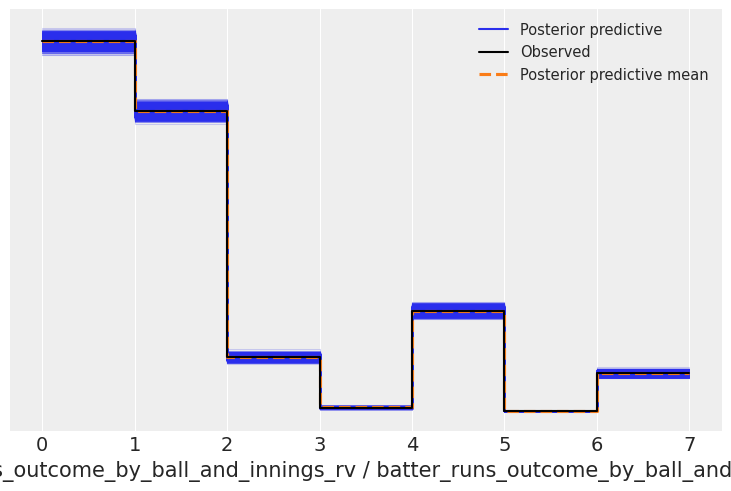

In [323]:
az.plot_ppc(idata)

In [343]:
first_innings_model.set_dim('ball_ids',
                             test_combined_df.shape[0],
                             coord_values = np.arange(train_combined_df.shape[0],
                                                      train_combined_df.shape[0]+test_combined_df.shape[0]))

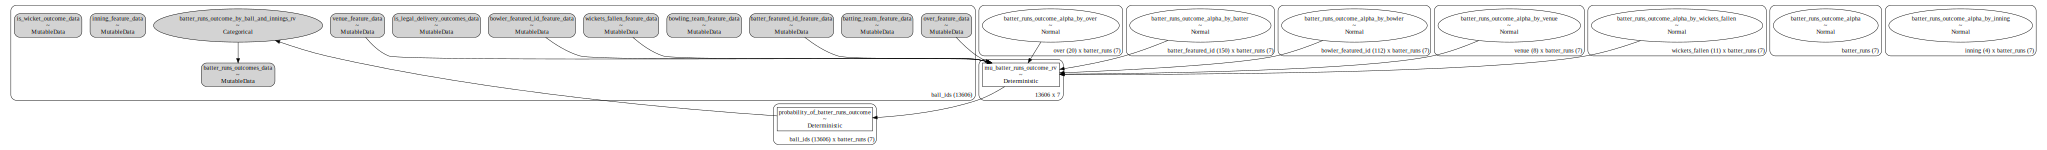

In [325]:
with first_innings_model:
    pm.set_data({
        'batter_runs_outcomes_data': test_combined_df['batter_runs'],
        "batter_featured_id_feature_data": test_combined_df['batter_featured_id'],
        "bowler_featured_id_feature_data": test_combined_df['bowler_featured_id'],
        "batting_team_feature_data": test_combined_df['batting_team'],
        "bowling_team_feature_data": test_combined_df['bowling_team'],
        "venue_feature_data": test_combined_df['venue'],
        "is_legal_delivery_outcomes_data": test_combined_df['is_legal_delivery'],
        "over_feature_data": test_combined_df['over'],
        "inning_feature_data": test_combined_df['inning'],     
        "wickets_fallen_feature_data": test_combined_df['wickets_fallen'],
        "is_wicket_outcome_data": test_combined_df['is_wicket'],
    })

pm.model_to_graphviz(first_innings_model)

In [326]:
with first_innings_model:
    idata = pm.sample_posterior_predictive(
            idata,
            predictions=True,
            extend_inferencedata=True,
            random_seed=RANDOM_SEED,
    )

Sampling: [batter_runs_outcome_by_ball_and_innings_rv]
2022-11-16 19:05:48.040 INFO    pymc: Sampling: [batter_runs_outcome_by_ball_and_innings_rv]


array([[<AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n25612'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n25613'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n25614'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n25615'}>],
       [<AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n25616'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n25617'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n25618'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n25619'}>],
       [<AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n25620'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n25621'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcom

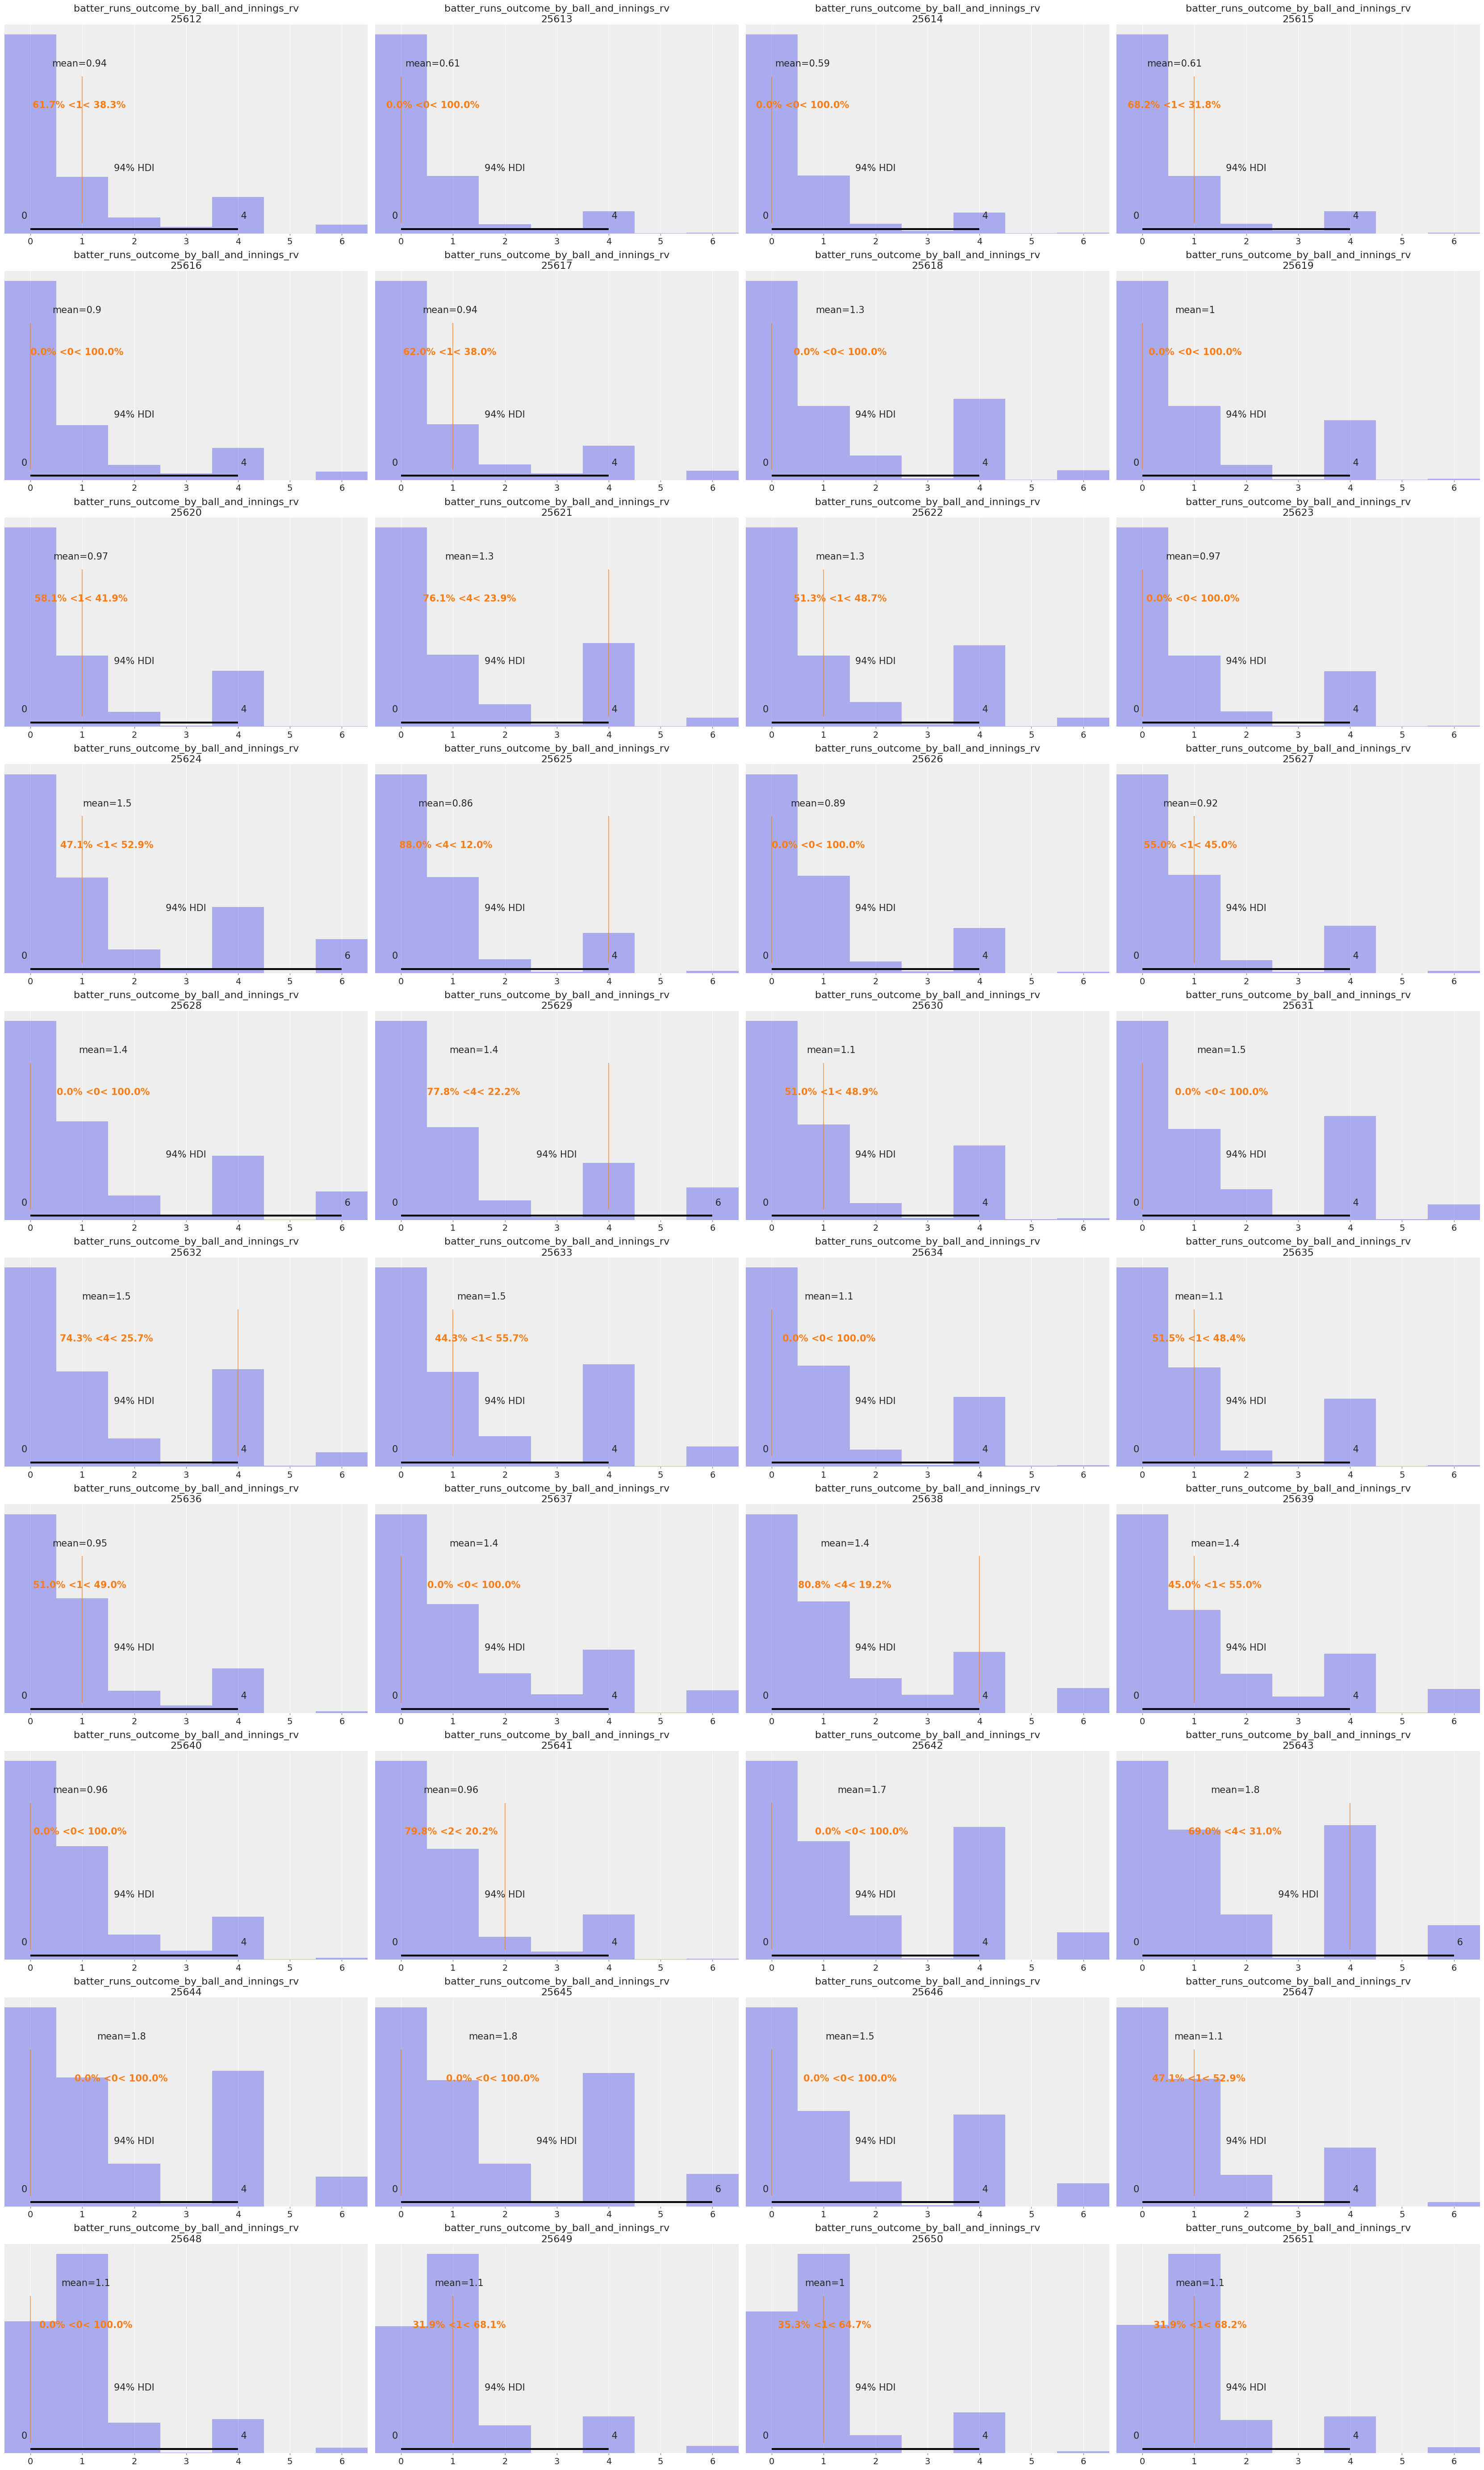

In [327]:
az.plot_posterior(
    idata.predictions,
    ref_val=test_combined_df.batter_runs.tolist(),
)

<AxesSubplot: >

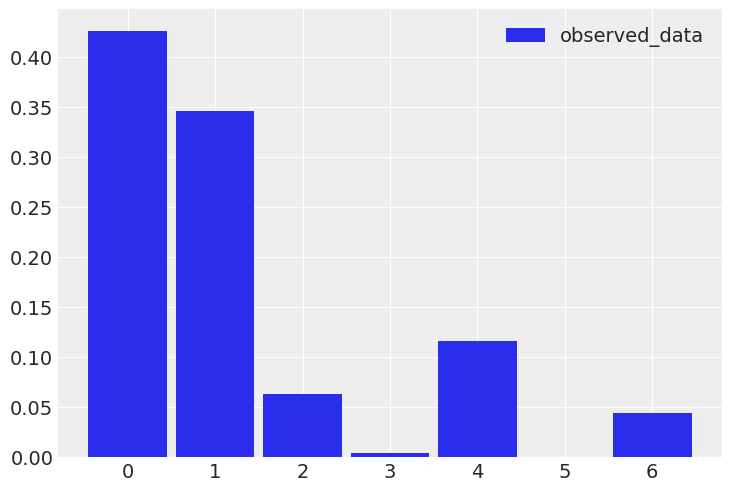

In [328]:
az.plot_dist(idata.observed_data["batter_runs_outcome_by_ball_and_innings_rv"], 
             color='C0', 
             label='observed_data')

<AxesSubplot: >

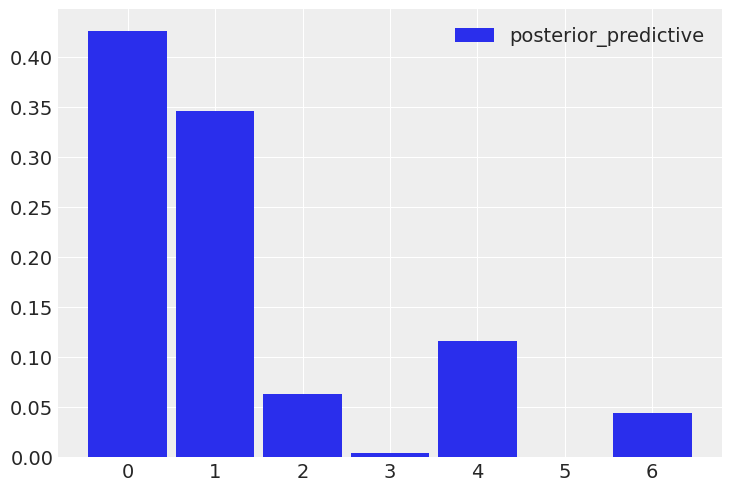

In [329]:
az.plot_dist(idata.posterior_predictive["batter_runs_outcome_by_ball_and_innings_rv"], 
             color='C0', 
             label='posterior_predictive')

<AxesSubplot: >

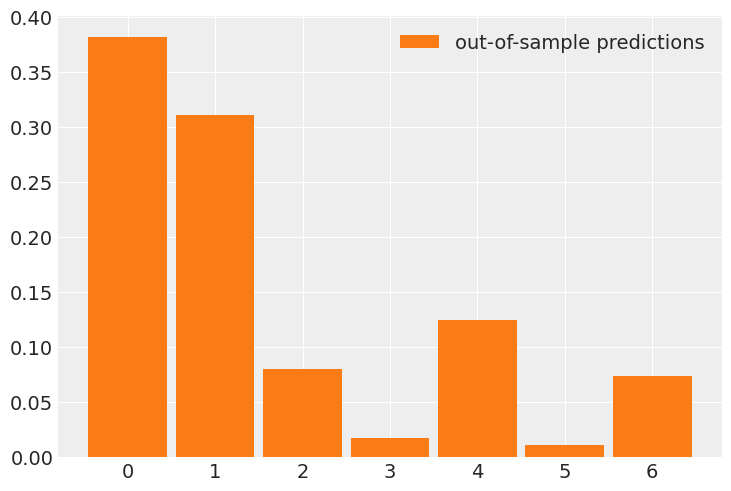

In [330]:
az.plot_dist(idata.predictions["batter_runs_outcome_by_ball_and_innings_rv"], 
             color='C1', 
             label = 'out-of-sample predictions')

In [331]:
def predictions_from_idata(idata,
                           var_name):
    preds_helper = lambda ds: ds.to_dataframe()[var_name].value_counts(normalize=True).to_xarray()
    predictions = (
        idata.predictions[var_name]
        .stack(dims=['chain','draw'])
        .groupby('ball_ids')
        .apply(preds_helper)
    )
    return predictions
    

In [332]:
predictions = predictions_from_idata(idata,
                                     'batter_runs_outcome_by_ball_and_innings_rv')

In [333]:
predictions

<xarray.DataArray 'batter_runs_outcome_by_ball_and_innings_rv' (
                                                                ball_ids: 13606,
                                                                index: 7)>
array([[6.17e-01, 1.75e-01, 4.95e-02, ..., 1.12e-01,      nan, 2.67e-02],
       [6.82e-01, 1.97e-01, 3.20e-02, ..., 7.52e-02, 2.50e-04, 2.25e-03],
       [6.85e-01, 1.99e-01, 3.25e-02, ..., 7.20e-02, 2.50e-04, 2.00e-03],
       ...,
       [5.99e-01, 1.98e-01, 5.45e-02, ..., 1.11e-01, 5.00e-04, 3.33e-02],
       [5.92e-01, 2.06e-01, 4.67e-02, ..., 1.18e-01, 5.00e-04, 3.30e-02],
       [5.91e-01, 2.10e-01, 4.95e-02, ..., 1.17e-01, 7.50e-04, 2.72e-02]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6
  * ball_ids  (ball_ids) int64 25612 25613 25614 25615 ... 39215 39216 39217

In [334]:
predictions_argmax = predictions.argmax('index')

In [335]:
predictions_max = predictions.max('index')

In [336]:
predictions_df = pd.DataFrame({'batter_runs':predictions_argmax.values,
                               'max':predictions_max.values})

In [337]:
predictions_df

,batter_runs,max
0,0,0.61675
1,0,0.68225
2,0,0.68550
3,0,0.68200
4,0,0.63050
...,...,...
13601,0,0.59225
13602,0,0.60025
13603,0,0.59875
13604,0,0.59225


In [338]:
from sklearn.metrics import classification_report, confusion_matrix
def print_cr_and_cm(true,pred):
    cr = classification_report(true,pred)
    cm = confusion_matrix(true,pred)
    print(cr)
    print(pd.DataFrame(cm))

In [339]:
print_cr_and_cm(test_combined_df.batter_runs,
                predictions_argmax)

              precision    recall  f1-score   support

           0       0.50      0.60      0.54      5859
           1       0.43      0.46      0.44      4861
           2       0.12      0.03      0.04       994
           3       0.01      0.02      0.01        60
           4       0.09      0.04      0.06      1321
           5       0.00      0.00      0.00         3
           6       0.07      0.04      0.05       508

    accuracy                           0.43     13606
   macro avg       0.17      0.17      0.16     13606
weighted avg       0.39      0.43      0.40     13606

      0     1    2   3    4   5    6
0  3509  1781   69  57  294  32  117
1  2170  2234  100  48  181  21  107
2   409   474   27   6   46   7   25
3    34    20    3   1    1   0    1
4   741   467   20  10   55   2   26
5     2     1    0   0    0   0    0
6   222   221   14   1   30   0   20


In [340]:
test_combined_no_idx = test_combined_df.reset_index()

In [341]:
def performance_for_idx(selection_idx,
                        prediction_df,
                        true_df):
    true_above_threshold = true_df.loc[selection_idx].batter_runs
    predicted_above_threshold = predictions_df.loc[selection_idx].batter_runs
    num_selected = selection_idx.sum()
    num_predicted = predictions_df.shape[0]
    pc_selected = num_selected*100/num_predicted
    print(f"\n{num_selected} selected out of {num_predicted}, selection pc = {pc_selected}")
    print_cr_and_cm(true_above_threshold,
                predicted_above_threshold)

In [342]:
## Check performance above threshold
def performance_above_threshold(threshold,
                                predictions_df,
                                true_df):
    above_threshold_idx = (predictions_df['max'] >= threshold)
    true_above_threshold = true_df.loc[above_threshold_idx].batter_runs
    predicted_above_threshold = predictions_df.loc[above_threshold_idx].batter_runs
    num_selected = above_threshold_idx.sum()
    num_predicted = predictions_df.shape[0]
    pc_selected = num_selected*100/num_predicted
    print(f"\n{num_selected} selected out of {num_predicted} at {threshold}, selection pc = {pc_selected}")
    print_cr_and_cm(true_above_threshold,
                predicted_above_threshold)


for threshold in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    performance_above_threshold(threshold,
                               predictions_df,
                               test_combined_no_idx)



13380 selected out of 13606 at 0.2, selection pc = 98.3389681023078
              precision    recall  f1-score   support

           0       0.49      0.61      0.54      5762
           1       0.43      0.46      0.44      4776
           2       0.12      0.03      0.04       979
           3       0.01      0.02      0.01        60
           4       0.09      0.04      0.06      1302
           5       0.00      0.00      0.00         3
           6       0.07      0.04      0.05       498

    accuracy                           0.43     13380
   macro avg       0.17      0.17      0.16     13380
weighted avg       0.39      0.43      0.40     13380

      0     1   2   3    4   5    6
0  3487  1761  55  52  271  30  106
1  2164  2198  89  45  170  19   91
2   409   468  25   6   43   6   22
3    34    20   3   1    1   0    1
4   740   461  17   9   52   2   21
5     2     1   0   0    0   0    0
6   221   217  12   1   29   0   18

11497 selected out of 13606 at 0.3, selection

In [344]:
train_batters = train_combined_df.batter_featured_id.unique().tolist()

In [345]:
from sklearn.metrics import jaccard_score
def calculate_overlap_for_batter_runs(target_runs,
                                      target_feature,
                                      predictions_df,
                                      true_df,
                                      k = 10):
    pred_idx = (predictions_df.batter_runs == target_runs)
    pred_top_k = true_df.loc[pred_idx][target_feature].value_counts(normalize=True).iloc[:k]

    true_idx = (true_df.batter_runs == target_runs)
    true_top_k = true_df.loc[true_idx][target_feature].value_counts(normalize=True).iloc[:k]
    inter = set(pred_top_k.index).intersection(true_top_k.index)
    return len(inter)/k

In [348]:
for target_runs in [0,1,2,4,6]:
    jc = calculate_overlap_for_batter_runs(target_runs,
                                           'batter_featured_id',
                                           predictions_df,
                                           test_combined_no_idx,
                                           k = 10)
    print(f'Score for {target_runs}: {jc}')

Score for 0: 0.6
Score for 1: 0.7
Score for 2: 0.4
Score for 4: 0.4
Score for 6: 0.5


In [349]:
for target_runs in [0,1,2,4,6]:
    jc = calculate_overlap_for_batter_runs(target_runs,
                                           'bowler_featured_id',
                                           predictions_df,
                                           test_combined_no_idx,
                                           k = 10)
    print(f'Score for {target_runs}: {jc}')

Score for 0: 0.8
Score for 1: 0.5
Score for 2: 0.1
Score for 4: 0.4
Score for 6: 0.5


In [350]:
def performance_for_idx(selection_idx,
                        prediction_df,
                        true_df):
    true_above_threshold = true_df.loc[selection_idx].batter_runs
    predicted_above_threshold = predictions_df.loc[selection_idx].batter_runs
    num_selected = selection_idx.sum()
    num_predicted = predictions_df.shape[0]
    pc_selected = num_selected*100/num_predicted
    print(f"\n{num_selected} selected out of {num_predicted}, selection pc = {pc_selected}")
    print_cr_and_cm(true_above_threshold,
                predicted_above_threshold)

In [351]:
def performance_by_feature(predictions_df,
                           true_df,
                           feature_name):
    for feature,freq in true_df[feature_name].value_counts(normalize=True).to_dict().items():
        selected_idx = true_df[feature_name] == feature
        print(f"\n {feature_name} = {feature}, {freq}")
        performance_for_idx(selected_idx,
                            predictions_df,
                            true_df)

In [353]:
selected_tournament

'Indian Premier League'

In [365]:
import pickle

def save_model(trace, network):
    with open (f'data/models/{selected_tournament}_{test_season}_orselection.pkl', 'wb') as buff:
        pickle.dump ({'trace': trace}, buff)

def load_model(model_name):
    with open (f'data/models/{model_name}', 'rb') as buff:
        data = pickle.load (buff)
    idata = data['trace']
    return idata

In [360]:
save_model(idata,f'{selected_tournament}_{test_season}_orselection.pkl')

In [366]:
idata_loaded = load_model(f'{selected_tournament}_{test_season}_orselection.pkl')

array([[<AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n0'}>,
        <AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n1'}>,
        <AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n2'}>],
       [<AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n3'}>,
        <AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n4'}>,
        <AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n5'}>],
       [<AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n6'}>,
        <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

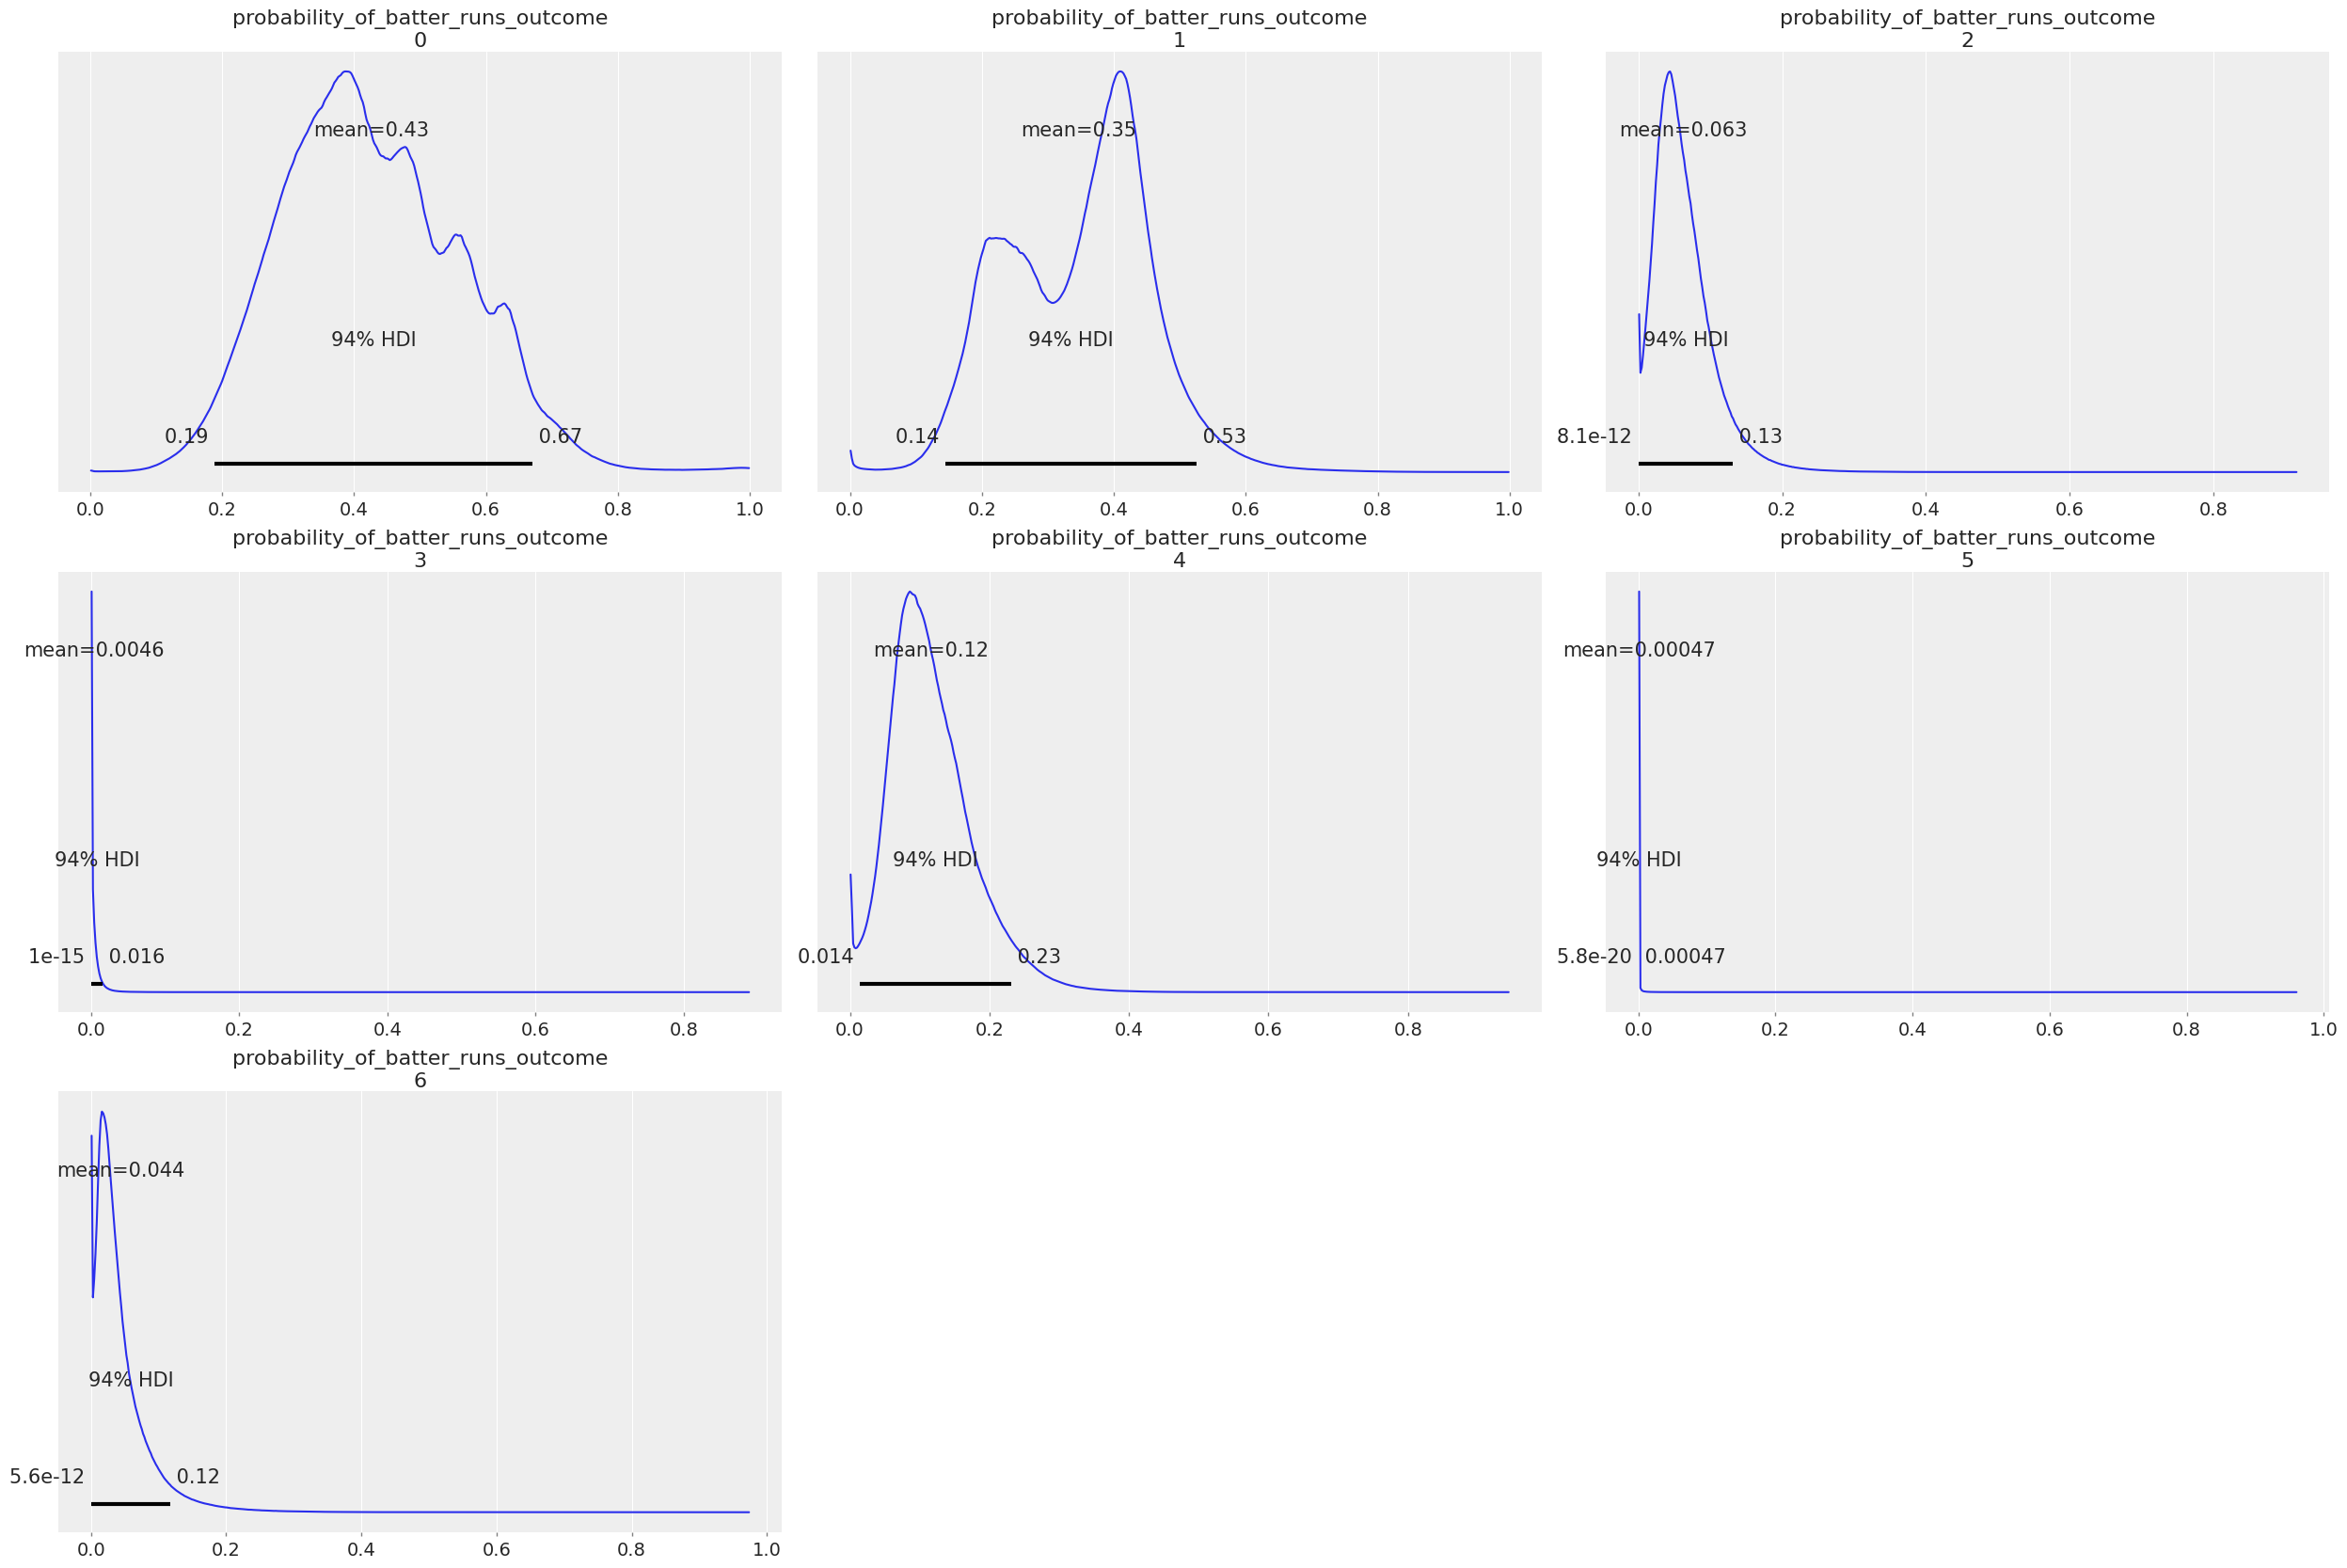

In [367]:
az.plot_posterior(idata_loaded.posterior,
                  var_names = ['probability_of_batter_runs_outcome'],
                  combine_dims = {'chain','draw','ball_ids'})

In [223]:
train_bowlers = train_combined_df.bowler_featured_id.unique().tolist()
bowlers_with_training_idx = (test_combined_df.bowler_featured_id.isin(train_bowlers)==False)
performance_for_idx(bowlers_with_training_idx,
                    predictions_df,
                    test_combined_no_idx)


6946 selected out of 13606, selection pc = 51.051006908716744
              precision    recall  f1-score   support

           0       0.50      0.53      0.52      2908
           1       0.41      0.47      0.44      2580
           2       0.10      0.13      0.11       523
           3       0.00      0.00      0.00        28
           4       0.08      0.02      0.03       656
           5       0.00      0.00      0.00         2
           6       0.02      0.01      0.01       249

    accuracy                           0.41      6946
   macro avg       0.16      0.16      0.16      6946
weighted avg       0.38      0.41      0.39      6946

      0     1    2  3   4  5   6
0  1552  1053  214  0  60  0  29
1   974  1205  302  0  50  0  49
2   166   265   66  0  11  0  15
3    11    16    0  0   1  0   0
4   292   274   62  0  11  0  17
5     2     0    0  0   0  0   0
6    88   122   30  0   7  0   2


In [356]:
os.getcwd()

'/Users/gireeshramji/PycharmProjects/SouthridgeCorp/player-outcome-predictor'

In [352]:
performance_by_feature(predictions_df,
                       test_combined_no_idx,
                       'over')


 over = 0, 0.05460826106129649

743 selected out of 13606, selection pc = 5.460826106129649
              precision    recall  f1-score   support

           0       0.65      0.90      0.75       480
           1       0.21      0.02      0.04       136
           2       0.00      0.00      0.00        29
           3       0.00      0.00      0.00         5
           4       0.11      0.05      0.07        79
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00        13

    accuracy                           0.59       743
   macro avg       0.14      0.14      0.12       743
weighted avg       0.47      0.59      0.50       743

     0   1  2   3   4  5  6
0  431  10  0  12  23  4  0
1  119   3  0   3   7  4  0
2   26   1  0   1   1  0  0
3    5   0  0   0   0  0  0
4   72   0  0   3   4  0  0
5    1   0  0   0   0  0  0
6   12   0  0   0   1  0  0

 over = 1, 0.0541672791415552

737 selected out of 13606, selection pc = 5.4167279141

              precision    recall  f1-score   support

           0       0.44      0.37      0.40       278
           1       0.46      0.61      0.52       311
           2       0.00      0.00      0.00        43
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00        14

    accuracy                           0.43       690
   macro avg       0.13      0.14      0.13       690
weighted avg       0.38      0.43      0.40       690

     0    1  2  3  4  5  6
0  104  164  6  2  0  0  2
1  101  190  8  1  2  0  9
2   17   22  0  1  3  0  0
3    2    1  0  0  0  0  0
4   11   27  1  1  0  0  0
5    0    1  0  0  0  0  0
6    2   12  0  0  0  0  0

 over = 10, 0.05049242981037778

687 selected out of 13606, selection pc = 5.049242981037778
              precision    recall  f1-score   support

           0       0.39      0.41     

In [226]:
performance_by_feature(predictions_df,
                       test_combined_no_idx,
                       'inning')


 inning = 0, 0.5160223430839336

7021 selected out of 13606, selection pc = 51.602234308393356
              precision    recall  f1-score   support

           0       0.51      0.60      0.55      2938
           1       0.43      0.40      0.41      2569
           2       0.08      0.12      0.10       525
           3       0.00      0.00      0.00        33
           4       0.08      0.03      0.04       682
           5       0.00      0.00      0.00         2
           6       0.06      0.05      0.06       272

    accuracy                           0.41      7021
   macro avg       0.17      0.17      0.17      7021
weighted avg       0.39      0.41      0.39      7021

      0     1    2  3   4  5   6
0  1753   779  258  3  82  0  63
1  1063  1020  310  1  85  0  90
2   197   208   62  0  24  0  34
3    14    13    3  0   2  0   1
4   320   226   85  1  18  0  32
5     2     0    0  0   0  0   0
6   100   104   35  1  18  0  14

 inning = 1, 0.4831691900632074

6574 sele

In [227]:
performance_by_feature(predictions_df,
                       test_combined_no_idx,
                       'venue')


 venue = 2, 0.2677495222695869

3643 selected out of 13606, selection pc = 26.774952226958696
              precision    recall  f1-score   support

           0       0.51      0.61      0.56      1560
           1       0.44      0.42      0.43      1343
           2       0.07      0.11      0.09       238
           3       0.00      0.00      0.00        11
           4       0.13      0.02      0.04       361
           6       0.06      0.02      0.02       130

    accuracy                           0.43      3643
   macro avg       0.20      0.20      0.19      3643
weighted avg       0.40      0.43      0.41      3643

     0    1    2  3   4   5
0  959  432  132  0  27  10
1  589  570  155  0  19  10
2   99  101   27  0   5   6
3    4    6    0  0   1   0
4  161  135   52  0   9   4
5   54   54   13  0   7   2

 venue = 7, 0.2106423636630898

2866 selected out of 13606, selection pc = 21.064236366308982
              precision    recall  f1-score   support

           0    

In [ ]:
performance_by_feature(predictions_df,
                       test_combined_no_idx,
                       'batter_featured_id')

In [ ]:
test_combined_no_idx.batter_featured_id.value_counts(normalize=True).iloc[:10]

In [247]:
target_runs = 6
pred_fours = (predictions_df.batter_runs == target_runs)
test_combined_no_idx.loc[pred_fours].batter_featured_id.value_counts(normalize=False).iloc[:10].index

Int64Index([20, 13, 69, 67, 17, 18, 146, 46, 28, 27], dtype='int64')

In [ ]:
train_combined_df.query(f'batter_runs == {target_runs}').batter_featured_id.value_counts(normalize=False).iloc[:10]

In [248]:
true_fours = (test_combined_no_idx.batter_runs == target_runs)
test_combined_no_idx.loc[true_fours].batter_featured_id.value_counts(normalize=False).iloc[:10].index

Int64Index([6, 69, 121, 103, 146, 64, 31, 144, 130, 22], dtype='int64')

In [ ]:
target_runs = 6
pred_fours = (predictions_df.argmax == target_runs)
test_combined_no_idx.loc[pred_fours].bowler_featured_id.value_counts(normalize=False).iloc[:10]

In [ ]:
true_fours = (test_combined_no_idx.batter_runs == target_runs)
test_combined_no_idx.loc[true_fours].bowler_featured_id.value_counts(normalize=False).iloc[:10]

In [ ]:
train_combined_df.query('batter_runs == 6').venue.value_counts(normalize=False).iloc[:10]

In [ ]:
performance_by_feature(predictions_df,
                       test_combined_no_idx,
                       'bowler_featured_id')

## Calculate % of scenarios for each ball where prediction is accurate

In [ ]:
def get_match_scenario_pc(ds):
    ball_id = ds.ball_ids.values
    num_matching_scenarios = (ds == test_combined_no_idx.iloc[ball_id-train_combined_df.shape[0]].batter_runs).sum()
    matching_scenarios_pc = num_matching_scenarios/4000
    #print(f"{num_matching_scenarios.values} scenarios, {matching_scenarios_pc.values} for {ball_id}")
    return matching_scenarios_pc

In [ ]:
matching_scenario_pc_by_ball = (
    idata.predictions['batter_runs_outcome_by_ball_and_innings_rv']
    .groupby('ball_ids')
    .apply(get_match_scenario_pc)
)

In [1039]:
matching_scenario_pc_by_batting_runs = pd.DataFrame({'matching_scenario_pc': matching_scenario_pc_by_ball.values,
                                                     'batter_runs': test_combined_df.batter_runs,
                                                     'batter_featured_id':test_combined_df.batter_featured_id.values,
                                                     'bowler_featured_id':test_combined_df.bowler_featured_id.values,
                                                     'venue': test_combined_df.venue.values,
                                                     'is_legal_delivery': test_combined_df.is_legal_delivery.values,
                                                     'over': test_combined_no_idx.over.values,
                                                     'inning': test_combined_no_idx.inning.values,
                                                     'match': test_combined_no_idx.match_key.values,
                                                     'is_wicket': test_combined_no_idx.is_wicket.values})

In [1040]:
COORDS['batter_runs']

Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')

<AxesSubplot: xlabel='batter_runs', ylabel='matching_scenario_pc'>

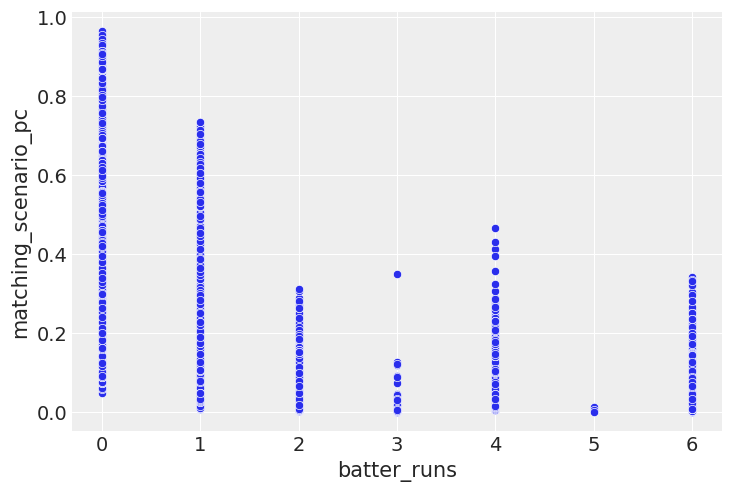

In [1041]:
sns.scatterplot(
    data = matching_scenario_pc_by_batting_runs,
    x = 'batter_runs',
    y = 'matching_scenario_pc'
)

<AxesSubplot: xlabel='venue', ylabel='matching_scenario_pc'>

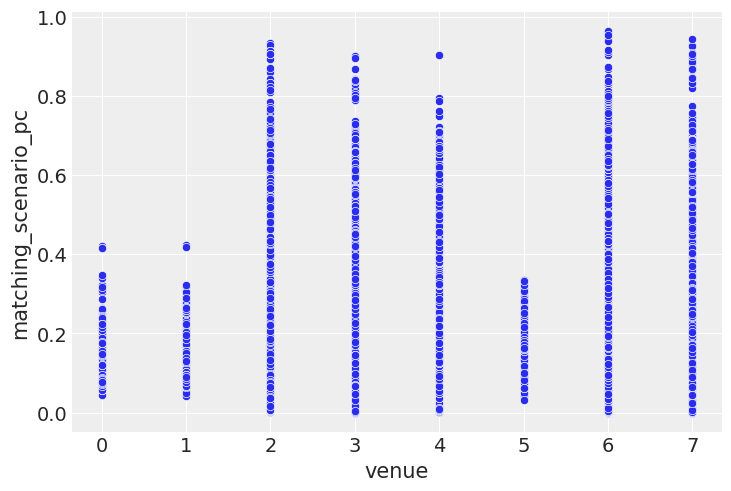

In [1042]:
sns.scatterplot(
    data = matching_scenario_pc_by_batting_runs,
    x = 'venue',
    y = 'matching_scenario_pc'
)

<AxesSubplot: xlabel='is_legal_delivery', ylabel='matching_scenario_pc'>

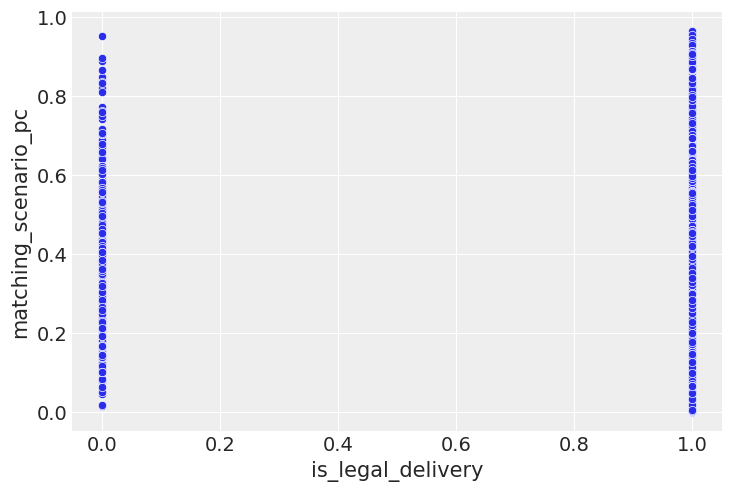

In [1043]:
sns.scatterplot(
    data = matching_scenario_pc_by_batting_runs,
    x = 'is_legal_delivery',
    y = 'matching_scenario_pc'
)

<AxesSubplot: xlabel='over', ylabel='matching_scenario_pc'>

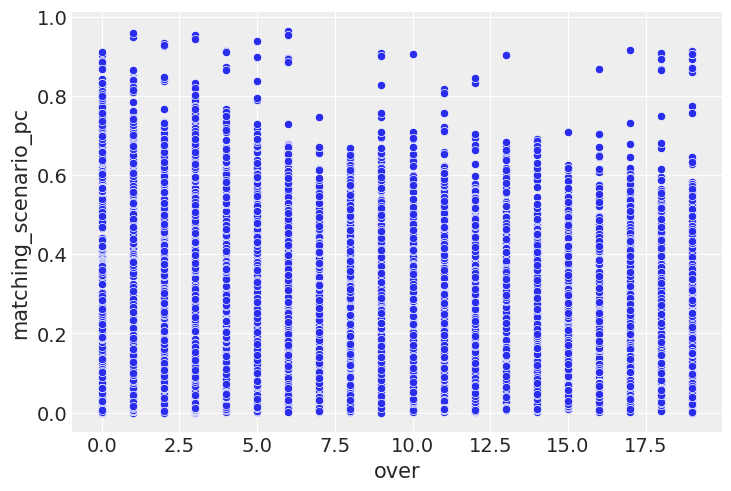

In [1044]:
sns.scatterplot(
    data = matching_scenario_pc_by_batting_runs,
    x = 'over',
    y = 'matching_scenario_pc'
)

<AxesSubplot: xlabel='inning', ylabel='matching_scenario_pc'>

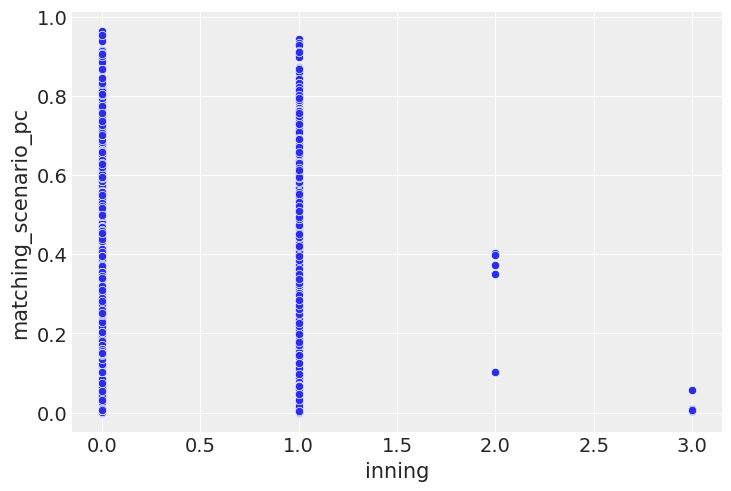

In [1045]:
sns.scatterplot(
    data = matching_scenario_pc_by_batting_runs,
    x = 'inning',
    y = 'matching_scenario_pc'
)

In [ ]:
sns.scatterplot(
    data = matching_scenario_pc_by_batting_runs,
    x = 'is_wicket',
    y = 'matching_scenario_pc'
)

In [ ]:
sns.scatterplot(
    data = matching_scenario_pc_by_batting_runs,
    x = 'batter_featured_id',
    y = 'matching_scenario_pc'
)

In [ ]:
sns.scatterplot(
    data = matching_scenario_pc_by_batting_runs,
    x = 'bowler_featured_id',
    y = 'matching_scenario_pc'
)

In [1049]:
train_combined_df.batter_featured_id.unique().shape 

(122,)

## Try traditional ML with OHE

In [111]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoders = {}
train_ohe_features = {}
test_ohe_features = {}

In [112]:
for feature in ['batter','bowler','venue','over','inning','wickets_fallen','is_wicket']:
    ohe = OneHotEncoder(sparse=False)
    all_features = pd.concat([train_match_state_df[[feature]],
                             test_season_match_state_df[[feature]]])
    ohe.fit(all_features)
    train_features = ohe.transform(train_match_state_df[[feature]])
    test_features = ohe.transform(test_season_match_state_df[[feature]])
    one_hot_encoders[feature] = ohe
    train_ohe_features[feature] = train_features
    test_ohe_features[feature] = test_features

In [113]:
for feature in ['innings_strike_rate']:
    train_ohe_features[feature] = train_match_state_df[[feature]].values
    test_ohe_features[feature] = test_season_match_state_df[[feature]].values

In [116]:
train_ohe_feature_array = np.hstack([v[1] for v in train_ohe_features.items() if v[0] in ['is_wicket','innings_strike_rate']])
test_ohe_feature_array = np.hstack([v[1] for v in test_ohe_features.items() if v[0] in ['is_wicket','innings_strike_rate']])

In [117]:
train_ohe_feature_array.shape

(243125, 3)

In [118]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(train_ohe_feature_array,
        train_bowling_outcomes_df['batter_runs'])

RandomForestClassifier()

In [119]:
predictions_rfc = clf.predict(test_ohe_feature_array)

In [120]:
predictions_rfc_df = pd.DataFrame({'batter_runs': predictions_rfc})

<AxesSubplot: >

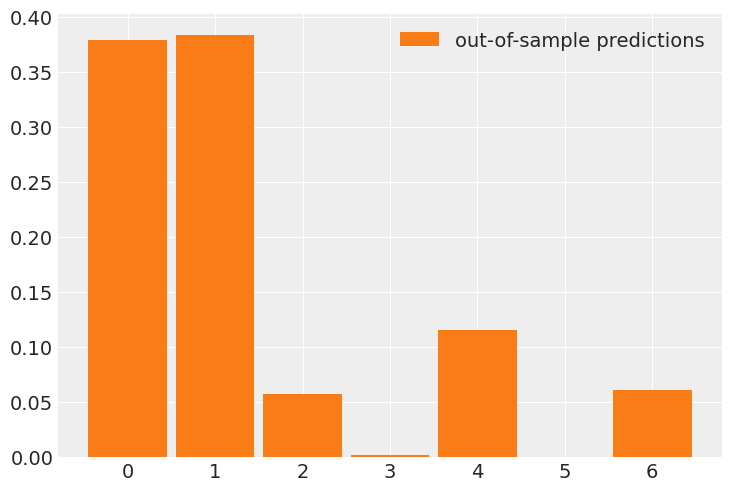

In [121]:
az.plot_dist(test_season_bowling_outcomes_df.batter_runs, 
             color='C1', 
             label = 'out-of-sample predictions')

<AxesSubplot: >

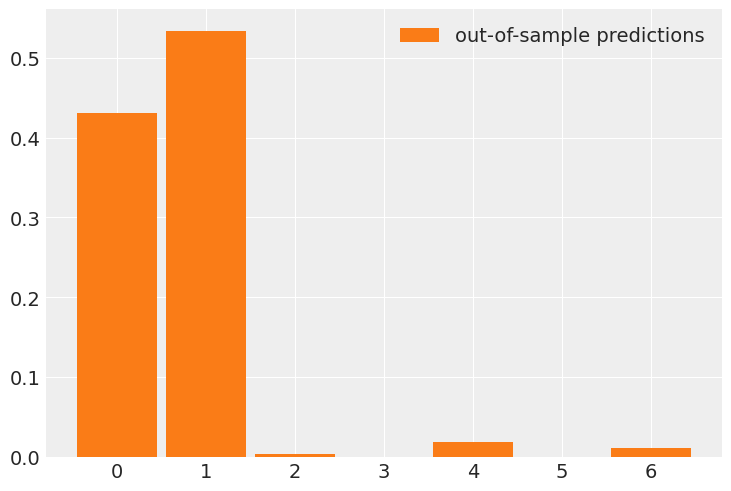

In [122]:
az.plot_dist(predictions_rfc_df.batter_runs, 
             color='C1', 
             label = 'out-of-sample predictions')

In [133]:
target_runs = 6
pred_fours = (predictions_rfc_df.batter_runs == target_runs)
test_season_match_state_df.loc[pred_fours].batter_featured_id.value_counts(normalize=False).iloc[:10]

SNe348     10
SWn615     10
SYv968      9
KRl943      8
SIr720      6
RTi3462     6
JBr161      6
CGe341      5
YSh604      5
ARl347      5
Name: batter_featured_id, dtype: int64

In [134]:
true_fours = (test_season_bowling_outcomes_df.batter_runs == target_runs)
test_season_match_state_df.loc[true_fours].bowler_featured_id.value_counts(normalize=False).iloc[:10]

DBo344     29
KYv289     24
STr1381    24
MSj971     21
SAHn238    20
SNe348     20
JUt2172    19
UYv970     19
RKn207     19
TBt732     18
Name: bowler_featured_id, dtype: int64